# Recurrent Network to Predict Multivariate Data

This notebook contains a basic, easy to understand and customize, Neural Network architecture template that can predict multiple dimensions for a single recurrent step from previous time series like data. A simple example is predicting both the X & Y coordinates of a ball moving around a 2D grid. A more complex example would be satellite imagery of a ship moving across the ocean.

Currently, most available code examples of similar models only predict a single output (class or true value) for each recurrent step.

Key highlights include: 
1.	Input/Output Data Structures
2.	Proper Scaling of the Data
3.	Activation Function Selection

This base template is easily enhanced to use more advanced recurrent cells (LSTM/GRU), add convolutional layers, additional dimensions, embeddings, network layers, etc.

The architecture of this model follows the traditional PyTorch “cadence”. Please see here for the excellent introduction videos on the PyTorch “cadence”.

https://github.com/hunkim/PyTorchZeroToAll


In [1]:
#Imports

import sys
import torch
import torch.nn as nn
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Example Data: 10 Data Points

# Number of dimensions we input and predict.
# In the basic example below the first 4 dimensions are the X & Y coordiantes of 2 objects moving around a small grid.
# The 5th dimension is the distance between the objects.

num_dims = 5   

x_data = [[0.0, 1.5, 1.9, 2.8, 3.2],
          [0.1, 1.4, 2.0, 2.9, 3.3],
          [0.2, 1.3, 2.1, 3.0, 3.4],
          [0.3, 1.2, 2.2, 3.1, 3.5],
          [0.4, 1.1, 2.3, 3.2, 3.6],
          [0.5, 1.0, 2.4, 3.1, 3.7],
          [0.4, 1.1, 2.5, 3.0, 3.8],
          [0.3, 1.2, 2.4, 2.8, 3.9],
          [0.2, 1.3, 2.3, 2.7, 3.8],
          [0.1, 1.4, 2.0, 2.6, 3.7]]

y_data = [[0.1, 1.4, 2.0, 2.9, 3.3],
          [0.2, 1.3, 2.1, 3.0, 3.4],
          [0.3, 1.2, 2.2, 3.1, 3.5],
          [0.4, 1.1, 2.3, 3.2, 3.6],
          [0.5, 1.0, 2.4, 3.1, 3.7],
          [0.4, 1.1, 2.5, 3.0, 3.8],
          [0.3, 1.2, 2.4, 2.8, 3.9],
          [0.2, 1.3, 2.3, 2.7, 3.8],
          [0.1, 1.4, 2.2, 2.6, 3.7],
          [0.0, 1.5, 2.1, 2.5, 3.6]]


# As we have one batch of samples, we will change them to variables only once
inputs = Variable(torch.Tensor(x_data))/4
labels = Variable(torch.Tensor(y_data))/4

In [3]:
#Model Parameters

input_size = num_dims  # Number of input dimensions
hidden_size = num_dims  # Output from the RNN. Number of output dimensions. This name can be confusing. Its the output size.
batch_size = 1   # One batch for the basic example
sequence_length = 1  # One by one
num_layers = 1  # One layer rnn

num_classes = 1  # Not really needed now as we are doing real number output not probibility

In [4]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size, batch_first=True, nonlinearity='tanh')

    def forward(self, hidden, x):
        # Reshape input (batch first)
        x = x.view(batch_size, sequence_length, input_size)

        # Propagate input through RNN
        # Input: (batch, seq_len, input_size)
        # hidden: (num_layers * num_directions, batch, hidden_size)
        out, hidden = self.rnn(x, hidden)
        return hidden, out.view(num_classes, -1)  # Watch this shape closely
               

    def init_hidden(self):
        # Initialize hidden and cell states
        # (num_layers * num_directions, batch, hidden_size)
        return Variable(torch.zeros(num_layers, batch_size, hidden_size))   # Init with 0s was slightly better than random
        #return Variable(torch.rand(num_layers, batch_size, hidden_size))


# Instantiate RNN model
model = Model()
print(model)

Model(
  (rnn): RNN(5, 5, batch_first=True)
)


In [9]:
# Set loss and Optimizer Function

criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.007, momentum = 0.5)

# Other Experimental Optimizer Choices
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.007)

In [6]:
# Train The Model
# The Goal With This Example Was To Overfit The Data

model.train()

for epoch in range(5000):
    if epoch == 500:
        print ('Change Lr at 500')
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, momentum = 0.5)
    optimizer.zero_grad()
    loss = 0
    hidden = model.init_hidden()
    predictions = np.zeros([1, 5])

    for input, label in zip(inputs, labels):  # TODO: I left this as a loop implementaion so its easier to understand
        label = label.unsqueeze(0)            # This can easily be refactored into a vectorized implementaion as is below in the test section
        hidden, output = model(hidden, input)
        
        loss += criterion(output, label)
        predictions = np.append(predictions,output.detach().numpy(),axis = 0)
    
    
    # Print the cost every 100 training iterations
    if epoch % 100 == 0:
        print("epoch: %d, loss: %1.6f" % (epoch, loss.item()))    

    loss.backward()
    optimizer.step()

print("Learning finished!")
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

print ('The label is: ' + str(label))
print ('The predict is: ' + str(output))
#print ("output: ", output.data[0])
#print ("hidden: ", hidden.data[0])

epoch: 0, loss: 12.391378
epoch: 100, loss: 0.016893
epoch: 200, loss: 0.012879
epoch: 300, loss: 0.009992
epoch: 400, loss: 0.007817
Change Lr at 500
epoch: 500, loss: 0.006239
epoch: 600, loss: 0.005565
epoch: 700, loss: 0.005157
epoch: 800, loss: 0.004816
epoch: 900, loss: 0.004519
epoch: 1000, loss: 0.004252
epoch: 1100, loss: 0.004009
epoch: 1200, loss: 0.003783
epoch: 1300, loss: 0.003572
epoch: 1400, loss: 0.003371
epoch: 1500, loss: 0.003179
epoch: 1600, loss: 0.002996
epoch: 1700, loss: 0.002820
epoch: 1800, loss: 0.002652
epoch: 1900, loss: 0.002492
epoch: 2000, loss: 0.002341
epoch: 2100, loss: 0.002197
epoch: 2200, loss: 0.002063
epoch: 2300, loss: 0.001937
epoch: 2400, loss: 0.001819
epoch: 2500, loss: 0.001710
epoch: 2600, loss: 0.001610
epoch: 2700, loss: 0.001518
epoch: 2800, loss: 0.001433
epoch: 2900, loss: 0.001357
epoch: 3000, loss: 0.001288
epoch: 3100, loss: 0.001226
epoch: 3200, loss: 0.001171
epoch: 3300, loss: 0.001122
epoch: 3400, loss: 0.001079
epoch: 3500, l

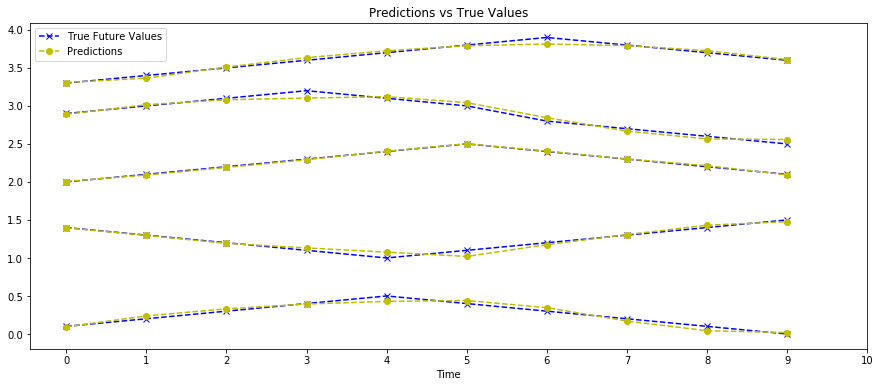

In [10]:
# Review The Data

full_labels = labels * 4
full_predictions = predictions * 4

plt.figure(num=1, figsize=(15, 6))

for k in range(num_dims):
    expected = full_labels.numpy()[:,k]
    pred = full_predictions [1:,k]
     
    label2 = "True Future Values" if k==0 else "_nolegend_"
    label3 = "Predictions" if k==0 else "_nolegend_"
        
    plt.plot(expected, "x--b", label=label2)
    plt.plot(pred, "o--y", label=label3)
        
plt.xlabel('Time')
plt.xticks(np.arange(0, 11, 1.0))

    
plt.legend(loc='best')
plt.title("Predictions vs True Values")
plt.show()



In [8]:
#Try Some Test Data

#Set to eval
model.eval()

#Init Hidden
hidden = model.init_hidden()

#1 Datapoint Test
sequence_length = 1
test_x_data = [0.1, 1.4, 2.0, 2.6, 3.7]


#last 5 Test Datapoints
#sequence_length = 5
#test_x_data = [[0.5, 1.0, 2.4, 3.1, 3.7],  
#               [0.4, 1.1, 2.5, 3.0, 3.8],
#               [0.3, 1.2, 2.4, 2.8, 3.9],
#               [0.2, 1.3, 2.3, 2.7, 3.8],
#               [0.1, 1.4, 2.0, 2.6, 3.7]]

#Some Random Datapoints
#sequence_length = 5
#test_x_data = [[0.1, 3.0, 0.4, 3.1, 2.7],  
#               [0.2, 3.1, 0.5, 3.0, 2.8],
#               [0.3, 3.2, 0.4, 2.8, 2.9],
#               [0.2, 3.3, 0.3, 2.7, 2.8],
#               [0.11, 3.4, 0.0, 2.6, 2.7]]


test_inputs = Variable(torch.Tensor(test_x_data))/4
batch_size = 1
hidden, outputs = model(hidden,test_inputs)


# Print Out Good Stuff
#print (hidden)
print (outputs[:,-5:]*4)
#print (outputs*4)
print ("True Vals: [0.0,   1.5,     2.1,      2.5,      3.6]")

tensor([[-0.0697,  1.3884,  2.0853,  2.6002,  3.5508]], grad_fn=<MulBackward>)
True Vals: [0.0,   1.5,     2.1,      2.5,      3.6]
